In [36]:
from IPython.display import HTML
#Add button to toggle code - http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle raw code."></form>''')

In [35]:
%matplotlib inline

from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.client import GoogleCredentials
import itertools
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

matplotlib.style.use('ggplot')

#Set GOOGLE_APPLICATION_CREDENTIALS environment variable
credentials = GoogleCredentials.get_application_default()
bigquery_service = build('bigquery', 'v2', credentials=credentials)

with open('config.json') as json_config:
    config = json.load(json_config)
    
project_id = config['project_id']

In [32]:
query_request = bigquery_service.jobs()

query = '''select
            type, %s as payload_type, count(type)
            from githubarchive:month.%s
            where type = 'CreateEvent'
            group by 1,2 limit 100;'''

years = ['2014','2015','2016']
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
dates = [y+m for y,m in list(itertools.product(years,months))]
query_results = []
for date in dates:
    try:
        #data format changes in January 2015 - use different column names before and after
        column_name = 'payload_ref_type' if int(date) < 201500 else "JSON_EXTRACT(payload, '$.ref_type')"
        query_data = {
                    'query': (query %(column_name, date))
        }
        query_response = query_request.query(
                    projectId=project_id,
                    body=query_data).execute()
        
        for row in query_response['rows']:
            payload_type = row['f'][1]['v']
            value = int(row['f'][2]['v'])
            query_results.append({'date':date, 'payload_type':payload_type, 'value':value})
    except: pass

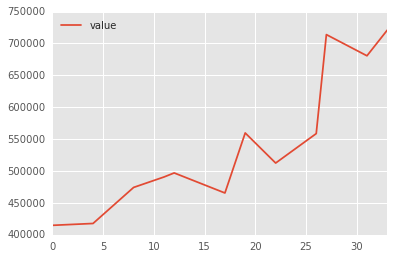

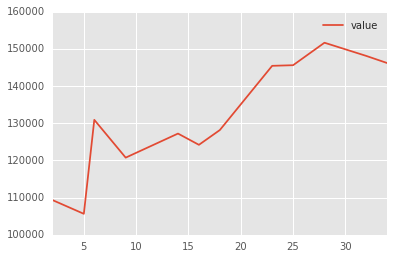

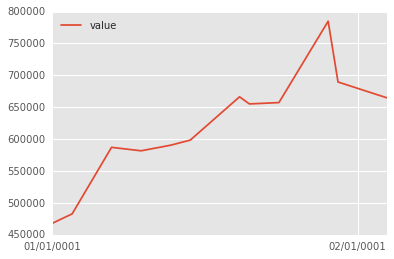

In [34]:
df = pd.DataFrame(query_results)
df['date'] = pd.to_datetime(df.date, format='%Y%m')
df.set_index(df['date'])
df[df['payload_type']=='repository'][['value']].plot(label='Repositories')
df[df['payload_type']=='tag'][['value']].plot(label='Tags')
df[df['payload_type']=='branch'][['value']].plot(label='Branches')

#data = df[['date','value']].plot()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())